In [1]:
import rebound
import sys
#change the next line to reflect where you have downloaded the source code
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
import sbdynt as sbd


# *Tools to directly set up a rebound integration*
The calls above are integrated into these functions

**Example of setting up an integration with clones for a single object**

Note that the rebound simulation will have the following units:

distance: au

time: years (1 year==365.25 days)

mass: solar masses

In [ ]:
#Set up an empty simulation, specify the small body and number of clones
sim= rebound.Simulation()
sbody = 'K14X40T'
clones = 5

#initialize the simulation with the giant planets (can include all the major planets)
flag, epoch, sim = sbd.initialize_simulation(planets=['Jupiter','Saturn','Uranus','Neptune'],
                                                 des=sbody, clones=clones)

#print out the simulation status
if(flag):
    print("Sucessfully added ", sbody, "to a simulation at epoch ", epoch)
    print("the best fit clone has a heliocentric orbit of:")
    
    helio_orbit = sim.particles[sbody+"_bf"].calculate_orbit(sim.particles[0])
    print("a=",helio_orbit.a)
    print("e=",helio_orbit.e)
    print("i=",helio_orbit.inc)
    print("node=",helio_orbit.Omega)
    print("aperi=",helio_orbit.omega)
    print("mean anomaly=",helio_orbit.M)
    
    print("\n"+"or a barycentric orbit of:")
    
    helio_orbit = sim.particles[sbody+"_bf"].calculate_orbit(sim.calculate_com())
    print("a=",helio_orbit.a)
    print("e=",helio_orbit.e)
    print("i=",helio_orbit.inc)
    print("node=",helio_orbit.Omega)
    print("aperi=",helio_orbit.omega)
    print("mean anomaly=",helio_orbit.M)    
    
    
    sim.status()


You could proceed from here with regular rebound commands, but we have also included some tools
to directly run the rebound simulations, writing outputs to a simulation archive binary file

The simulation defaults to using rebound's mercurius integrator with reasonable 
default choices for the timestep based on the planets in the simulation. **Note that the simulation
does not check to see if a small body gets closer to the sun than the innermost included planet!!! This
means that the integration timestep might become unreasonable if the small body evolves too far inward.**
(Or you could be missing important perturbers, such as the terrestrial planets, if you initialized the 
simulation with only the outer planets! Check for such conditions when analyzing the output)

In [ ]:
#max time in the integration (years)
tmax = 1e6

#how often you want to save the simulation archive file
tout = 1e3
savefile = "archive.bin"

#sun the simulation, deleting any existing simulation archive
flag, sim = sbd.run_simulation(sim, tmax=tmax, tout=tout,filename=savefile,deletefile=True)

if(flag):
    print("Simulation ran to ", sim.t, " years")

**Example of setting up an integration with a list of small bodies**

(no clones allowed in this instance as the cloning procedure relies on orbit-fits that have independent epochs!)



In [ ]:
# Example of setting up an integration with a list of small bodies (no clones allowed)

#Set up an empty simulation, specify the small body and number of clones
sim= rebound.Simulation()
# note that designations can be packed, unpacked, numbers, comets, etc
list_of_sbodies = ['K14X40T','2016 SW50', '15760','29P','179P/Jedicke']

#initialize the simulation without specifying planets (it will thus include all the major planets)
flag, epoch, sim = sbd.initialize_simulation_at_epoch(des=list_of_sbodies, epoch=2457019.)

#print out the simulation status
if(flag):
    sim.status()


**Example of setting up an integration with just the planets at a spefied epoch**

Note that if not all planets are included in a simulation, we correct for that, so this routine also returns the necessary cartesian correction to the heliocentric position and velocity vectors of any small bodies you want to add to the simulation. 

You must use these corrections *before* using a sim.move_to_com() command!




In [ ]:
sim= rebound.Simulation()
epoch = 2457387.5
flag, sim, dx, dy, dz, dvx, dvy, dvz = sbd.add_planets(sim,epoch=epoch)
if(flag):
    print("All major planets were included so the corrections are all zero: ")
    print(dx,dy,dz,dvx,dvy,dvz)

In [ ]:
sim= rebound.Simulation()
epoch = 2457387.5
flag, sim, dx, dy, dz, dvx, dvy, dvz = sbd.add_planets(sim,
                                                           planets=['Jupiter','Saturn','Uranus', 'Neptune'],
                                                           epoch=epoch)
if(flag):
    print("Only the giant planets are included, so the corrections are non-zero: ")
    print(dx,dy,dz)
    print(dvx,dvy,dvz)
    
    #when adding small bodies by observed heliocentric orbit, you should convert to cartesian using the GM
    #value for the sun used for that heliocentric orbit fit and then add them to the simulation using 
    #the above corrections
    
    #Example, suppose you have an orbit calculated at the above epoch using Find_Orb with the following
    #orbital elements:
    a = 39.4060972335126 #(semimajor axis in au)
    ec = 0.19121388131996062 #(eccentricity)
    inc=0.1279988198070029 #radians! (inclination relative to the ecliptic)
    node = -2.3766713138417384 #radians! (longitude of ascending node)
    argperi = 3.033977870435759 #radians! (argument of pericenter)
    ma = 0.15683745626851575 #radians! (mean anomaly)
    
    #You need the value of GMsun used by Find_Orb, which we have in a constants file
    import hard_coded_constants as const

    # We need to convert the Find_Orb orbit to heliocentric
    # cartesian variables using Find_Orb's assumed solar GM
    # which is in km^2/s^2, so have to convert a to km first
    a = a/const.kmtoau
    #now we use a built-in tool to convert to heliocentric cartesian
    aeiflag, x, y, z, vx, vy, vz = sbd.aei_to_xv(GM=const.find_orb_sunGM, 
                    a=a, e=ec, inc=inc, node=node, argperi=argperi, ma=ma)
    # those positions and velocities are in km and km/s, so need to convert
    # to au/year
    x=x*const.kmtoau
    y=y*const.kmtoau
    z=z*const.kmtoau
    vx=vx*const.kmtoau/const.stoyear
    vy=vy*const.kmtoau/const.stoyear
    vz=vz*const.kmtoau/const.stoyear
    
    #now we can apply the corrections from add_planets to make them heliocentric
    x+=dx; y+=dy; z+=dz;
    vx+=dvx; vy+=dvy; vz+=dvz;
    
    #finally we can add a test particle to sim with that corrected orbit:
    sim.add(m=0., x=x, y=y, z=z, vx=vx, vy=vy, vz=vz, hash="test-orbit")
    
    helio_orbit = sim.particles["test-orbit"].calculate_orbit(sim.particles[0])

    print("Added heliocentric orbit: ")
    print("a=",helio_orbit.a)
    print("e=",helio_orbit.e)
    print("i=",helio_orbit.inc)
    print("node=",helio_orbit.Omega)
    print("aperi=",helio_orbit.omega)
    print("mean anomaly=",helio_orbit.M)
    
    print("\n"+"Simulation with the corrected small body orbit included: ")
    sim.status()



# **Example plots from the integration of K14X40T above**

There are two ways to read the simualtion archive file with the build in functions: by hash or by small body name (which will read in all the clones too if there are any)

In [2]:
#first by hash, where the best-fit always has the hash sbody_bf
sbody = 'K14X40T'
savefile = 'archive.bin'
nclones=5
flag, abf, ebf, incbf, nodebf, aperibf, mabf, t = sbd.read_sa_by_hash(obj_hash = sbody+"_bf", archivefile=savefile)
#you can read the planet evolution this way too

/Users/kvolk/anaconda3/envs/sbdynt/lib/python3.11/site-packages/rebound/simulationarchive.py:148: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [3]:
#now reading all the clones (the best fit will be indexed 0, then clones)
flag, a, e, inc, node, aperi, ma, t = sbd.read_sa_for_sbody(sbody=sbody, archivefile=savefile,nclones=nclones)

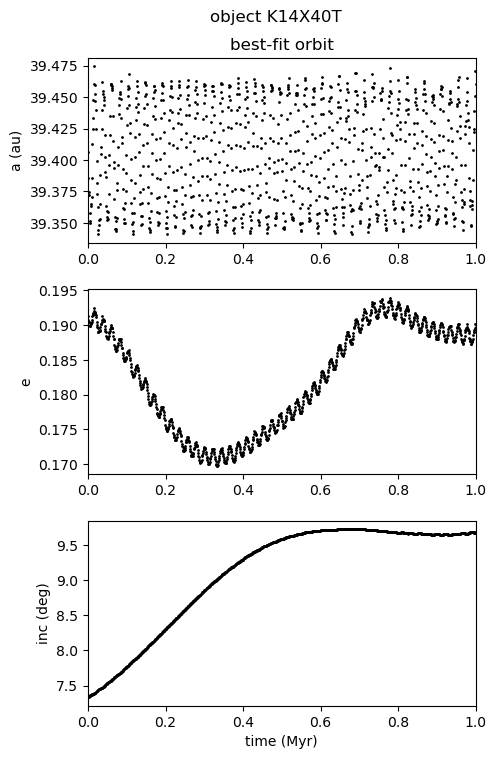

In [4]:
#plot just the best-fit orbit (no clones)
#figfile can be omitted if you don't want to save the figure
flag = sbd.plot_aei(sbody=sbody,a=a,e=e,inc=inc,t=t,nclones=0,figfile='example-K14X40T-bf-aei.png')

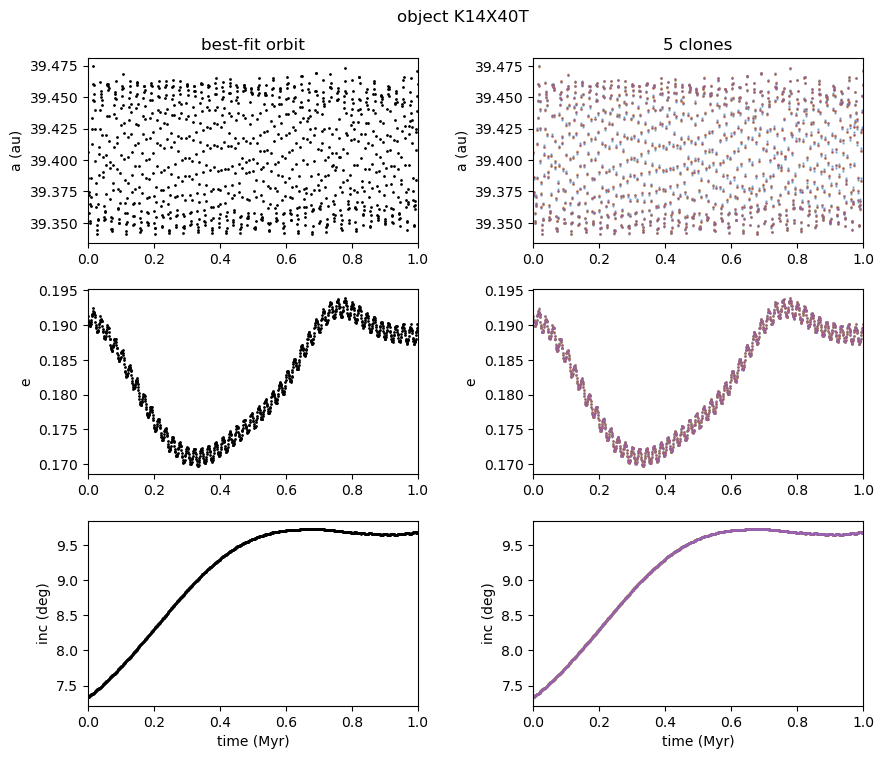

In [5]:
#make a two-column plot that also shows the clones
flag = sbd.plot_aei(sbody=sbody,a=a,e=e,inc=inc,t=t,
                    nclones=nclones,figfile='example-K14X40T-bf-and-clones-aei.png')

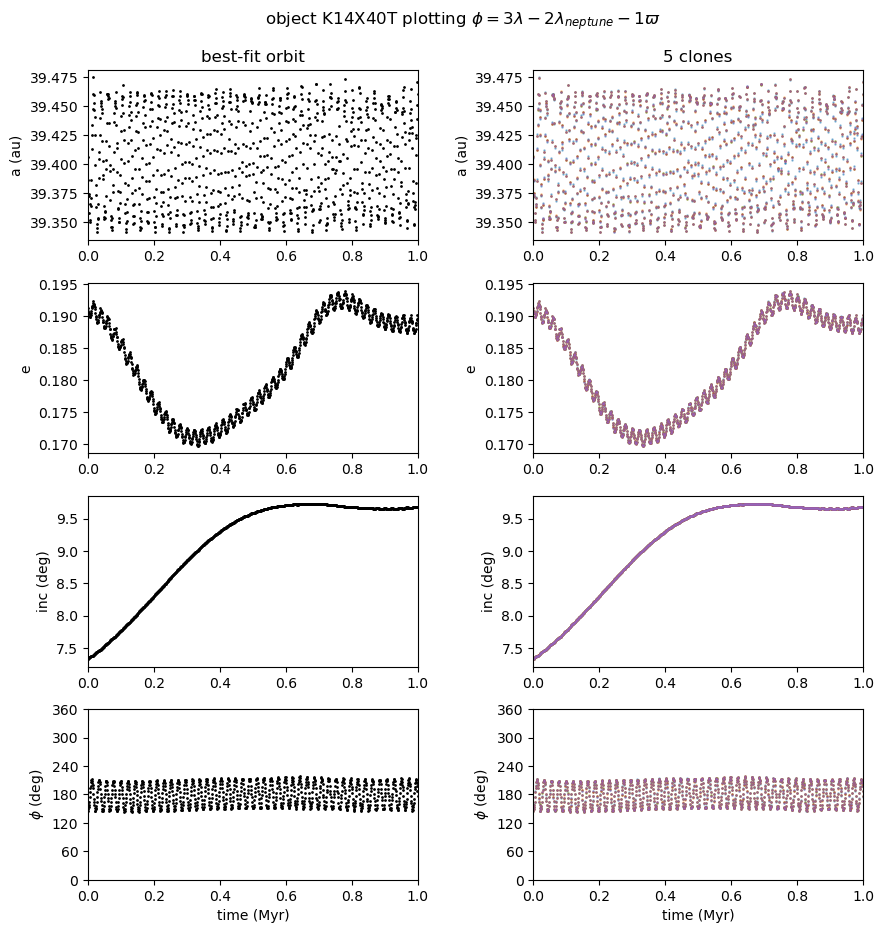

In [6]:
#this TNO happens to be a plutino, so you can also plot the resonant evolution
#first we go back to the simulation archive to calcaulte the resonant angle
#where for plutinos the p:q resonances is 3:2
(flag, a, e, inc, node, aperi, ma, phi, t,res_str) = sbd.read_sa_for_resonance(
                            sbody=sbody,
                            archivefile=savefile,planet='neptune',
                            p=3,q=2,nclones=nclones)
flag = sbd.plot_resonance(sbody=sbody,
                          res_string=res_str,
                          a=a,e=e,inc=inc,phi=phi,t=t,
                          nclones=nclones,figfile=None)